<a href="https://colab.research.google.com/github/chaobai/Cousera-DeepLearning.AI-TensorFlow-Developer/blob/master/C4%20-%20Sequences%2C%20Time%20Series%20and%20Prediction/W4/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-11-10 01:10:10--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2021-11-10 01:10:11 (12.0 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



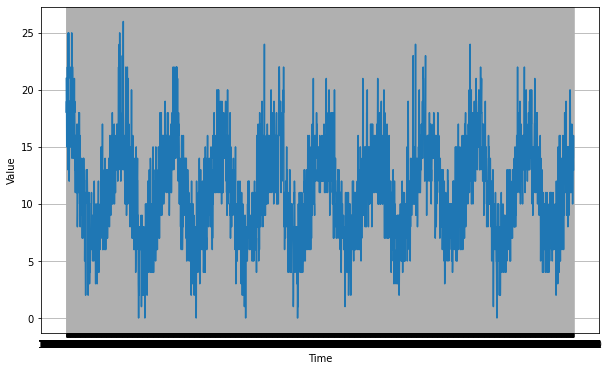

In [8]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  datastore = csv.reader(csvfile, delimiter=',')
  next(datastore, None)
  for i,row in enumerate(datastore):
    time_step.append(row[0])
    temps.append(round(float(row[1])))
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
split_time = 2500
time_train = time_step[:split_time] # YOUR CODE HERE
x_train = temps[:split_time] # YOUR CODE HERE
time_valid = time_step[split_time:] # YOUR CODE HERE
x_valid = temps[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 21s 32ms/step - loss: 31.1784 - mae: 31.6762 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 37ms/step - loss: 30.6004 - mae: 31.0981 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 37ms/step - loss: 29.7069 - mae: 30.2045 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 41ms/step - loss: 28.5884 - mae: 29.0858 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 38ms/step - loss: 27.2271 - mae: 27.7242 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 39ms/step - loss: 25.5361 - mae: 26.0329 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 40ms/step - loss: 23.3840 - mae: 23.8804 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 38ms/step - loss: 20.6559 - mae: 21.1519 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 1s 39ms/step - loss: 17.3547 - mae

(1e-08, 0.0001, 0.0, 60.0)

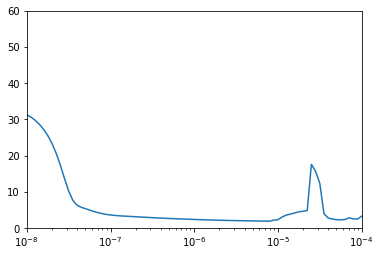

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 5s 22ms/step - loss: 14.1744 - mae: 14.6671
Epoch 2/30
25/25 [==============================] - 1s 23ms/step - loss: 3.0593 - mae: 3.5288
Epoch 3/30
25/25 [==============================] - 1s 23ms/step - loss: 1.8948 - mae: 2.3486
Epoch 4/30
25/25 [==============================] - 1s 23ms/step - loss: 1.7753 - mae: 2.2259
Epoch 5/30
25/25 [==============================] - 1s 24ms/step - loss: 1.7090 - mae: 2.1584
Epoch 6/30
25/25 [==============================] - 1s 24ms/step - loss: 1.6979 - mae: 2.1464
Epoch 7/30
25/25 [==============================] - 1s 24ms/step - loss: 1.6596 - mae: 2.1071
Epoch 8/30
25/25 [==============================] - 1s 24ms/step - loss: 1.6314 - mae: 2.0782
Epoch 9/30
25/25 [==============================] - 1s 23ms/step - loss: 1.6128 - mae: 2.0593
Epoch 10/30
25/25 [==============================] - 1s 24ms/step - loss: 1.5951 - mae: 2.0404
Epoch 11/30
25/25 [==============================] - 1s 2

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

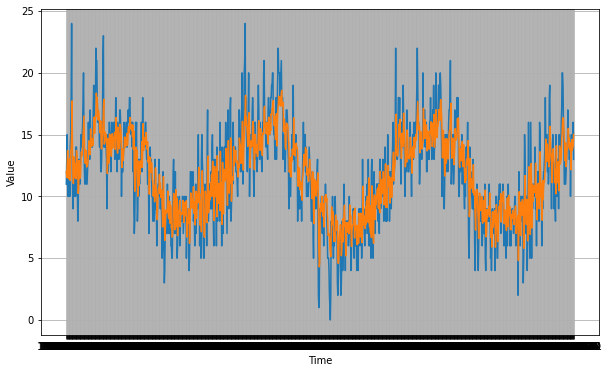

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7982887

In [22]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.005876 11.52723  12.733358 ... 13.930761 14.033109 15.019046]
